In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e15/sample_submission.csv
/kaggle/input/playground-series-s3e15/data.csv
/kaggle/input/predicting-heat-flux/Data_CHF_Zhao_2020_ATE.csv


In [2]:
df=pd.read_csv('/kaggle/input/playground-series-s3e15/data.csv')
df.head()

,id,author,geometry,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
0,0,Thompson,tube,7.00,3770.0,0.1754,NaN,10.8,432.0,3.6
1,1,Thompson,tube,NaN,6049.0,-0.0416,10.3,10.3,762.0,6.2
2,2,Thompson,NaN,13.79,2034.0,0.0335,7.7,7.7,457.0,2.5
3,3,Beus,annulus,13.79,3679.0,-0.0279,5.6,15.2,2134.0,3.0
4,4,NaN,tube,13.79,686.0,NaN,11.1,11.1,457.0,2.8


In [3]:
df.columns

Index(['id', 'author', 'geometry', 'pressure [MPa]', 'mass_flux [kg/m2-s]',
       'x_e_out [-]', 'D_e [mm]', 'D_h [mm]', 'length [mm]',
       'chf_exp [MW/m2]'],
      dtype='object')

finding count of total number of rows as well

In [4]:
df.shape[0]

31644

In [5]:
null_values=df['x_e_out [-]'].isnull().sum()
count=df.shape[0]
null_percentage=(null_values/count)*100
null_percentage

32.913032486411325

looking out for outliers via box plot detection

<Axes: ylabel='x_e_out [-]'>

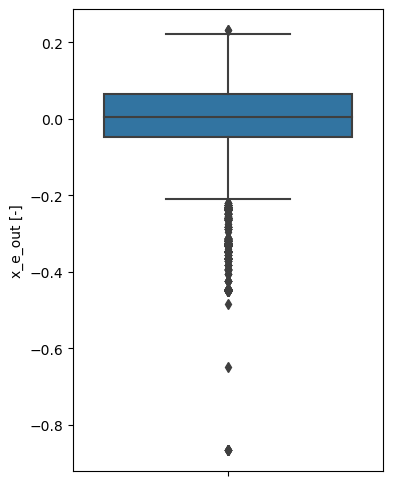

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
#Outlier detection using Boxplot
plt.figure(figsize=(4,6))
sns.boxplot(y ="x_e_out [-]", data = df)

In [7]:
from xgboost import XGBRegressor 

In [8]:
df.isnull().sum()

id                         0
author                  5024
geometry                5500
pressure [MPa]          4452
mass_flux [kg/m2-s]     4791
x_e_out [-]            10415
D_e [mm]                5488
D_h [mm]                4589
length [mm]             4759
chf_exp [MW/m2]            0
dtype: int64

1.K-Nearest Neighbors (KNN) Imputation:

KNN imputation is a non-parametric method that imputes missing values by finding the K nearest neighbors based on other features and using their values to estimate the missing values.
It can handle missing values in other features because it only considers non-missing values when determining the nearest neighbors.
The imputation is performed by taking the mean or median of the neighbors' values. Let us use KNN Imputation to try and get some missing values imputed

In [9]:
y1=df['x_e_out [-]']
X1=df.drop('x_e_out [-]',axis=1)
dfKNN=df.copy()
dfKNN=df.select_dtypes(exclude='object')

viewing the seperated data for performing accurate KNN imputation

In [10]:
from sklearn.impute import KNNImputer
imputer=KNNImputer()
dfKNN_imputed=imputer.fit_transform(dfKNN)
dfKNN_imputed=pd.DataFrame(dfKNN_imputed,columns=dfKNN.columns)

checking if all null values have been imputed accordingly

In [11]:
dfKNN_imputed.isnull().sum().sum()

0

vieweing the target column accordingly as needed to

In [12]:
dfKNN_imputed['x_e_out [-]']

0        0.17540
1       -0.04160
2        0.03350
3       -0.02790
4        0.01864
          ...   
31639    0.08860
31640   -0.02874
31641   -0.12240
31642   -0.01556
31643    0.06030
Name: x_e_out [-], Length: 31644, dtype: float64

In [13]:
df1=pd.read_csv('/kaggle/input/predicting-heat-flux/Data_CHF_Zhao_2020_ATE.csv')
df1.head()

,id,author,geometry,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
0,1,Inasaka,tube,0.39,5600,-0.1041,3.0,3.0,100,11.3
1,2,Inasaka,tube,0.31,6700,-0.0596,3.0,3.0,100,10.6
2,3,Inasaka,tube,0.33,4300,-0.0395,3.0,3.0,100,7.3
3,4,Inasaka,tube,0.62,6400,-0.1460,3.0,3.0,100,12.8
4,5,Inasaka,tube,0.64,4700,-0.0849,3.0,3.0,100,11.0


In [14]:
df1.columns

Index(['id', 'author', 'geometry', 'pressure [MPa]', 'mass_flux [kg/m2-s]',
       'x_e_out [-]', 'D_e [mm]', 'D_h [mm]', 'length [mm]',
       'chf_exp [MW/m2]'],
      dtype='object')

In [15]:
df1.isnull().sum()

id                     0
author                 0
geometry               0
pressure [MPa]         0
mass_flux [kg/m2-s]    0
x_e_out [-]            0
D_e [mm]               0
D_h [mm]               0
length [mm]            0
chf_exp [MW/m2]        0
dtype: int64

In [16]:
df1.shape

(1865, 10)

In [17]:
df.shape

(31644, 10)

filling the entire data csv with its mean values 

In [18]:
df_mean=df.fillna(df.mean(),inplace=False)

/tmp/ipykernel_20/1680852710.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_mean=df.fillna(df.mean(),inplace=False)


In [19]:
df_mean.isna().sum()

id                        0
author                 5024
geometry               5500
pressure [MPa]            0
mass_flux [kg/m2-s]       0
x_e_out [-]               0
D_e [mm]                  0
D_h [mm]                  0
length [mm]               0
chf_exp [MW/m2]           0
dtype: int64

In [20]:
sub=pd.read_csv('/kaggle/input/playground-series-s3e15/sample_submission.csv')
sub

,id,x_e_out [-]
0,4,0.0
1,7,0.0
2,10,0.0
3,12,0.0
4,23,0.0
...,...,...
10410,31633,0.0
10411,31634,0.0
10412,31637,0.0
10413,31640,0.0


selecting all the rows from the sample submission that we need to select from our predicted imputed values

In [21]:
y_pred = df_mean.loc[df_mean['id'].isin(sub['id']), 'x_e_out [-]']

In [22]:
y_pred

4       -0.000453
7       -0.000453
10      -0.000453
12      -0.000453
23      -0.000453
           ...   
31633   -0.000453
31634   -0.000453
31637   -0.000453
31640   -0.000453
31642   -0.000453
Name: x_e_out [-], Length: 10415, dtype: float64

creating a submission accordingly

In [23]:
sub=sub.set_index("id")
sub

,x_e_out [-]
id,
4,0.0
7,0.0
10,0.0
12,0.0
23,0.0
...,...
31633,0.0
31634,0.0
31637,0.0


In [24]:
sub['x_e_out [-]']=dfKNN_imputed['x_e_out [-]']
sub

,x_e_out [-]
id,
4,0.01864
7,0.08950
10,-0.02574
12,0.02720
23,0.08012
...,...
31633,0.07038
31634,-0.03234
31637,0.00596


In [25]:
sub.isnull().sum()

x_e_out [-]    0
dtype: int64

In [26]:
sub.to_csv("submission.csv")